<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [1]:
import nltk
from nltk import FreqDist
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

In [2]:
import random
random.seed(0)
np.random.seed(0)

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [3]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [4]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [5]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [6]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [7]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [8]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [9]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

tag_num = pd.Series(FreqDist(tags)).sort_values(ascending=False) # тег - кол-во тега в корпусе
word_num = pd.Series(FreqDist(words)).sort_values(ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [10]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

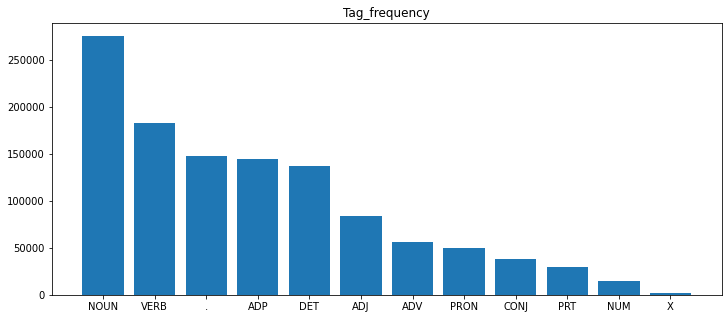

In [11]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [12]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

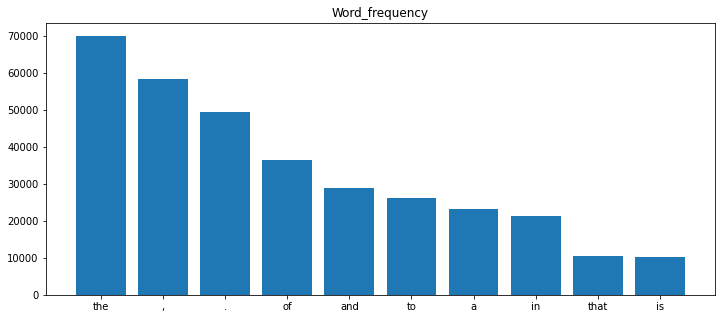

In [13]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [14]:
word_num['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [15]:
tag = FreqDist(tags).max()
MOST_POPULAR_WORD_TAG = FreqDist(filter(lambda t:t[1]==tag, brown_tagged_words)).max()
MOST_POPULAR_WORD_TAG

('time', 'NOUN')

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [16]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [17]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

train_sents, test_sents = train_test_split(my_brown_tagged_sents, random_state=0, test_size=0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [18]:
len(train_sents)

947

In [19]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [20]:
class HiddenMarkovModel:    
    def __init__(self, most_popular_word_tag=None):
        self.most_popular_word_tag = most_popular_word_tag if most_popular_word_tag is not None else MOST_POPULAR_WORD_TAG
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_num = pd.Series(FreqDist(tags)).sort_index()
        word_num = pd.Series(FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index

         
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B

        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = list(test_tokens_list[i_sent]) # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = self.most_popular_word_tag[0]
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] =  np.max(q[t] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                      
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [21]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [22]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
my_model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

In [23]:
my_model.predict([["Colorless", "green", "ideas", "sleep", "furiously"]])

OrderedDict([(0,
              array(['NOUN', 'NOUN', 'NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

как видим для простых кейсов работает неплохо. но на сложных везде NOUN;)

### Вопрос 3:
* Какой тег вы получили для слова `can`?

VERB, но можно и отдельно проверить

In [24]:
my_model.predict([['can']])

OrderedDict([(0, array(['VERB'], dtype='<U4'))])

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

NOUN , но давайте в отрыве от контекста проверим

In [25]:
my_model.predict([['favourite']])

OrderedDict([(0, array(['NOUN'], dtype='<U4'))])

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [26]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        nn = np.array(sent)
        tags = nn[:,1]
        words = nn[:,0]

        outputs = model.predict([words])[0]

        true_pred += np.sum(outputs == tags)
        num_pred += len(outputs)
    print(f"{true_pred / num_pred * 100:.1f}")

### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [27]:
accuracy_score(my_model, test_sents)

88.8


## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [28]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger("NOUN")

In [29]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = default_tagger.tag(words)
    outputs = [tag for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print(f"{true_pred / num_pred * 100:.1f}")

20.2


как видим такой способ в целом дает результат довольно плохой, хотя 20% (или пятая часть) это скорее про дистрибуцию популярного тега 

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [30]:
from nltk.tag.mapping import map_tag

In [31]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [32]:
nltk_result = [nltk.pos_tag(list(map(lambda t:t[0], s)), tagset='universal') for s in test_sents]

In [33]:
true_pred = sum((1 for t1,t2 in zip(nltk_result,test_sents) for tt1,tt2 in zip(t1,t2) if tt1[1]==tt2[1]))
num_pred = sum(1 for s in test_sents for _ in s)
print(f"{true_pred / num_pred * 100:.1f}")

89.2


In [34]:
%%capture
!pip install -q rnnmorph

In [35]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [36]:
rnnmorph_result = predictor.predict_sentences([list(map(lambda t:t[0], s)) for s in test_sents])

In [37]:
true_pred = sum((1 for t1,t2 in zip(rnnmorph_result,test_sents) for tt1,tt2 in zip(t1,t2) if tt1.pos==tt2[1]))
num_pred = sum(1 for s in test_sents for _ in s)
print(f"{true_pred / num_pred * 100:.1f}")

63.2


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

>nltk_model = 89.2, rnnmorph_model = 63.2

действительно nltk лучше себя показала и лучше даже той модели, что делали выше. ну из того , что на поверхности, rnnmorph использует другую систему тегов и по идее ее нужно еще тренировать на нашем train set , из анализа исходников двух библиотек, https://github.com/IlyaGusev/rnnmorph/blob/4acc539ab9ffdbb831ce91efbe4654315860246f/rnnmorph/data_preparation/process_tag.py#L6  , видно что rnnmorph использует для русского языка OpenCorpora формат, который конвертируется в universal , для английского universal, т.е. вопрос, на чем дефолтная модель была натренирована. так-то https://www.nltk.org/_modules/nltk/tag/mapping.html видно, что системы все же не взаимно-однозначны, а следовательно будут перекосы, влияющие на "распределение" меток при конверте, а следовательно и на результат качества.

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [38]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [39]:
import torchtext
# workaround due to breaking changes of the new torchvision version
try:
  from torchtext.data import Field, BucketIterator, Example, Dataset
except:
  from torchtext.legacy.data import Field, BucketIterator, Example, Dataset


# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам известны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [40]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [41]:
# кладем примеры в наш датасет
dataset = Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [42]:
WORD.build_vocab(train_data, min_freq=1)
TAG.build_vocab(train_data)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 4140
Unique tokens in target (en) vocabulary: 13
['<unk>', 'own', 'caught', 'getting', 'broke', 'literary', 'speaking', 'anecdote', 'bouanahsha', 'commiserate', 'derivation', 'escaped', 'gauge', 'independence', 'loon', 'non-repetitious', "poitrine's", 'remove', 'shoestring', 'suspense', 'usurious']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [43]:
print(vars(train_data.examples[9]))

{'words': ['one', 'of', 'the', 'many', 'things', 'that', 'was', 'so', 'nice', 'about', 'her', 'was', 'that', 'she', 'always', 'took', 'your', 'questions', 'seriously', ',', 'particularly', 'your', 'very', ',', 'very', 'serious', 'questions', '.'], 'tags': ['NUM', 'ADP', 'DET', 'ADJ', 'NOUN', 'PRON', 'VERB', 'ADV', 'ADJ', 'ADP', 'DET', 'VERB', 'ADP', 'PRON', 'ADV', 'VERB', 'DET', 'NOUN', 'ADV', '.', 'ADV', 'DET', 'ADV', '.', 'ADV', 'ADJ', 'NOUN', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

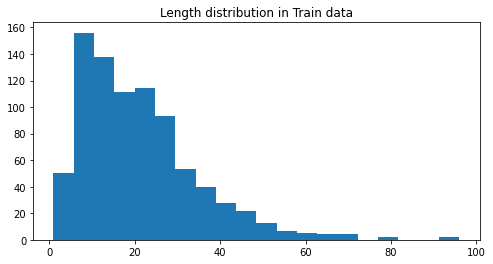

In [44]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [45]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [46]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [47]:
# посмотрим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[27, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [67]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False, num_layers=2):
        super().__init__()
        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, bidirectional=bidirectional)
        
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)
        

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 128
DROPOUT = 0.3
BIDIRECTIONAL = True
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(4140, 100)
  (dropout): Dropout(p=0.3, inplace=False)
  (rnn): LSTM(100, 128, num_layers=2, bidirectional=True)
  (tag): Linear(in_features=256, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [49]:
def count_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,048,125 trainable parameters


Погнали обучать

In [50]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        words, tags = batch.words, batch.tags  
        
        optimizer.zero_grad()
        
        output = model(words)
        
        #tags = [sent len, batch size]
        #output = [sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        tags = tags.view(-1)
        
        #tags = [sent len * batch size]
        #output = [sent len * batch size, output dim]
        
        loss = criterion(output, tags)
        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            words, tags = batch.words, batch.tags  

            output = model(words)

            #tags = [sent len, batch size]
            #output = [sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            tags = tags.view(-1)

            #tags = [sent len * batch size]
            #output = [sent len * batch size, output dim]

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

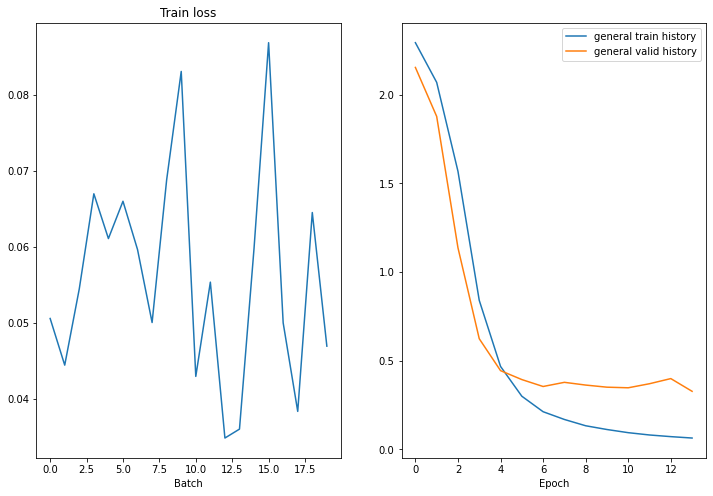

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.056 | Train PPL:   1.057
	 Val. Loss: 0.360 |  Val. PPL:   1.434


In [51]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Применение модели

In [52]:
@torch.no_grad()
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    for i, batch in enumerate(iterator):

        words, tags = batch.words, batch.tags
        output = model(words)
        
        #output = [sent len, batch size, output dim]
        output = output.argmax(-1)
        
        #output = [sent len, batch size]
        predict_tags = output.cpu().numpy()
        true_tags = tags.cpu().numpy()

        true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
        num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
        
    return round(true_pred / num_pred * 100, 3)

In [54]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 89.721 %


хм, неплохо, но что если...немного другая инициализация и дропаут

In [56]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence
from typing import *



class VariationalDropout(nn.Module):
    """
    Applies the same dropout mask across the temporal dimension
    See https://arxiv.org/abs/1512.05287 for more details.
    Note that this is not applied to the recurrent activations in the LSTM like the above paper.
    Instead, it is applied to the inputs and outputs of the recurrent layer.
    """
    def __init__(self, dropout: float, batch_first: Optional[bool]=False):
        super().__init__()
        self.dropout = dropout
        self.batch_first = batch_first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.dropout <= 0.:
            return x

        is_packed = isinstance(x, PackedSequence)
        if is_packed:
            x, batch_sizes = x
            max_batch_size = int(batch_sizes[0])
        else:
            batch_sizes = None
            max_batch_size = x.size(0)

        # Drop same mask across entire sequence
        if self.batch_first:
            m = x.new_empty(max_batch_size, 1, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        else:
            m = x.new_empty(1, max_batch_size, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        x = x.masked_fill(m == 0, 0) / (1 - self.dropout)

        if is_packed:
            return PackedSequence(x, batch_sizes)
        else:
            return x

class LSTM(nn.LSTM):
    """
    source: https://github.com/keitakurita/Better_LSTM_PyTorch/blob/master/better_lstm/model.py
    """
    def __init__(self, *args, dropouti: float=0.,
                 dropoutw: float=0., dropouto: float=0.,
                 batch_first=True, unit_forget_bias=True, **kwargs):
        super().__init__(*args, **kwargs, batch_first=batch_first)
        self.unit_forget_bias = unit_forget_bias
        self.dropoutw = dropoutw
        self.input_drop = VariationalDropout(dropouti,
                                             batch_first=batch_first)
        self.output_drop = VariationalDropout(dropouto,
                                              batch_first=batch_first)
        self._init_weights()

    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            nn.init.uniform_(param, -0.08, 0.08)
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data, gain=nn.init.calculate_gain('relu'))
            elif "bias" in name and self.unit_forget_bias:
                nn.init.zeros_(param.data)
                param.data[self.hidden_size:2 * self.hidden_size] = 1

    def _drop_weights(self):
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                getattr(self, name).data = \
                    torch.nn.functional.dropout(param.data, p=self.dropoutw,
                                                training=self.training).contiguous()

    def forward(self, input, hx=None):
        self._drop_weights()
        input = self.input_drop(input)
        seq, state = super().forward(input, hx=hx)
        return self.output_drop(seq), state




class LSTMTaggerAdditional(LSTMTagger):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__(input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional)
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.rnn = LSTM(emb_dim, hid_dim, num_layers=2, bidirectional=bidirectional)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)
        

        


INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 128
DROPOUT = 0.1
BIDIRECTIONAL = True
model = LSTMTaggerAdditional(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
# model.apply(init_weights)
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

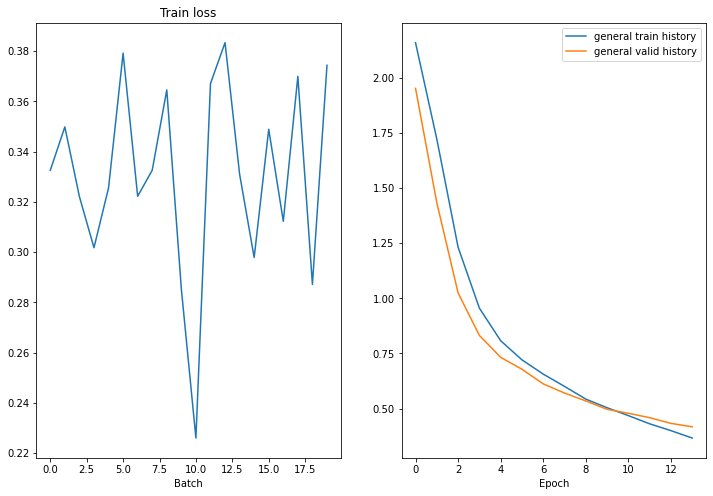

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.335 | Train PPL:   1.398
	 Val. Loss: 0.406 |  Val. PPL:   1.501


In [57]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [58]:
print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 84.696 %


фокус не удался

Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [55]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

train_sents, test_sents = train_test_split(my_brown_tagged_sents, random_state=0, test_size=0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


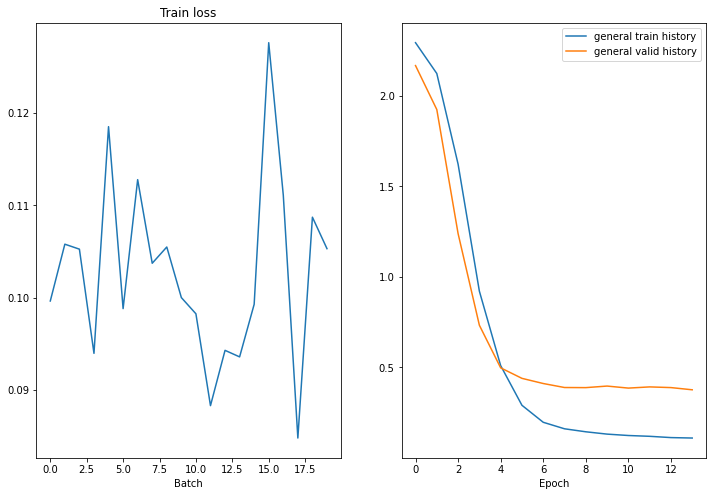

Epoch: 15 | Time: 0m 0s
	Train Loss: 0.106 | Train PPL:   1.112
	 Val. Loss: 0.399 |  Val. PPL:   1.490


In [63]:
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 128
DROPOUT = 0.3
BIDIRECTIONAL = True
model = LSTMTaggerAdditional(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
model.apply(init_weights)
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')
best_valid_acc = 0

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    valid_acc = accuracy_model(model, test_iterator)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'best-val-model.pt')
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [120]:
def check_model(EMB_DIM, HID_DIM, DROPOUT, BIDIRECTIONAL, NUM_LAYERS, N_EPOCHS, CLIP=1, W_INIT=0.08):
      try:
        os.remove('best-val-model.pt')
      except:
        pass

      def init_weights(m):
        for name, param in m.named_parameters():
          nn.init.uniform_(param, -W_INIT, W_INIT)
        

      INPUT_DIM = len(WORD.vocab)
      OUTPUT_DIM = len(TAG.vocab)
      model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL, num_layers=NUM_LAYERS).to(device)
      model.apply(init_weights)
      PAD_IDX = TAG.vocab.stoi['<pad>']
      optimizer = optim.Adam(model.parameters())
      criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


      train_history = []
      valid_history = []

      best_valid_loss = float('inf')
      best_valid_acc = 0
      best_epoch = 0

      # es = EarlyStopping(patience=5)

      for epoch in range(N_EPOCHS):
          
          start_time = time.time()
          
          train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
          valid_loss = evaluate(model, valid_iterator, criterion)
          
          valid_acc = accuracy_model(model, test_iterator)
          
          end_time = time.time()
          
          epoch_mins, epoch_secs = epoch_time(start_time, end_time)
          
          # if valid_loss < best_valid_loss:
          #     best_valid_loss = valid_loss
          #     torch.save(model.state_dict(), 'best-val-model.pt')
          if valid_acc > best_valid_acc:
              best_valid_acc = valid_acc
              best_epoch = epoch
              torch.save(model.state_dict(), 'best-val-model.pt')
          
          # if es.step(valid_acc):
          #   break

          train_history.append(train_loss)
          valid_history.append(valid_loss)
          print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
          print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
          print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
      model.load_state_dict(torch.load('best-val-model.pt'))
      return model, best_epoch

было проверено несколько параметров, в несколько заходов

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>BIDIRECTIONAL</th>
      <th>CLIP</th>
      <th>DROPOUT</th>
      <th>EMB_DIM</th>
      <th>HID_DIM</th>
      <th>NUM_LAYERS</th>
      <th>N_EPOCHS</th>
      <th>W_INIT</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>4</th>
      <td>91.229</td>
      <td>True</td>
      <td>1</td>
      <td>0.3</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>1</th>
      <td>91.457</td>
      <td>True</td>
      <td>1</td>
      <td>0.2</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>0</th>
      <td>92.417</td>
      <td>True</td>
      <td>1</td>
      <td>0.2</td>
      <td>100</td>
      <td>1024</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>2</th>
      <td>92.736</td>
      <td>True</td>
      <td>1</td>
      <td>0.2</td>
      <td>100</td>
      <td>512</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>3</th>
      <td>92.965</td>
      <td>True</td>
      <td>1</td>
      <td>0.3</td>
      <td>100</td>
      <td>1024</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
  </tbody>
</table>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>BIDIRECTIONAL</th>
      <th>CLIP</th>
      <th>DROPOUT</th>
      <th>EMB_DIM</th>
      <th>HID_DIM</th>
      <th>NUM_LAYERS</th>
      <th>N_EPOCHS</th>
      <th>W_INIT</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2</th>
      <td>89.539</td>
      <td>True</td>
      <td>1</td>
      <td>0.3</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>1</th>
      <td>90.818</td>
      <td>True</td>
      <td>1</td>
      <td>0.2</td>
      <td>100</td>
      <td>512</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>0</th>
      <td>90.955</td>
      <td>True</td>
      <td>1</td>
      <td>0.2</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>6</th>
      <td>91.000</td>
      <td>True</td>
      <td>2</td>
      <td>0.3</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>3</th>
      <td>91.594</td>
      <td>True</td>
      <td>1</td>
      <td>0.3</td>
      <td>100</td>
      <td>512</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>5</th>
      <td>91.777</td>
      <td>True</td>
      <td>2</td>
      <td>0.2</td>
      <td>100</td>
      <td>512</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>4</th>
      <td>92.097</td>
      <td>True</td>
      <td>2</td>
      <td>0.2</td>
      <td>100</td>
      <td>256</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>7</th>
      <td>92.325</td>
      <td>True</td>
      <td>2</td>
      <td>0.3</td>
      <td>100</td>
      <td>512</td>
      <td>2</td>
      <td>30</td>
      <td>0.08</td>
    </tr>
  </tbody>
</table>

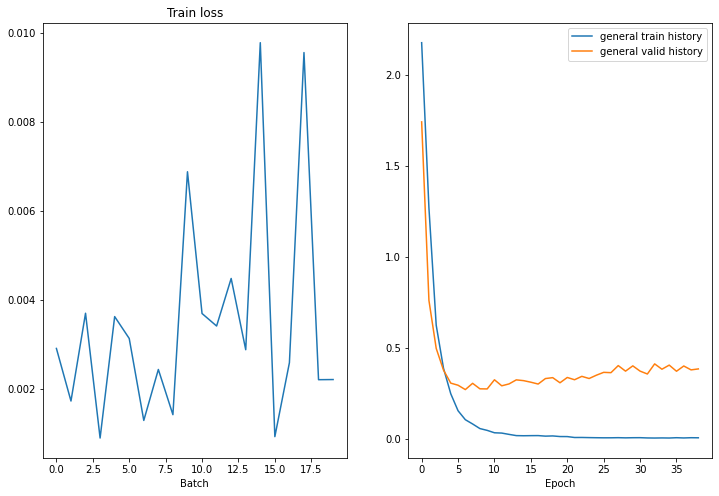

Epoch: 40 | Time: 0m 1s
	Train Loss: 0.004 | Train PPL:   1.004
	 Val. Loss: 0.353 |  Val. PPL:   1.423
acc=93.102 {'BIDIRECTIONAL': True, 'CLIP': 1.8, 'DROPOUT': 0.4, 'EMB_DIM': 100, 'HID_DIM': 1024, 'NUM_LAYERS': 2, 'N_EPOCHS': 40, 'W_INIT': 0.08}


In [123]:
from sklearn.model_selection import ParameterGrid

best_params = None
param_grid = {
    "EMB_DIM":[100], 
    "HID_DIM":[ 1024], 
    "DROPOUT":[0.4], 
    "BIDIRECTIONAL":[True], 
    "NUM_LAYERS":[2], 
    "N_EPOCHS":[40],
    "CLIP":[1.1, 1.4, 1.8], 
    "W_INIT":[0.08]
}


history_acc = []
for params in ParameterGrid(param_grid):
  model, best_epoch = check_model(**params)
  acc = accuracy_model(model, test_iterator)
  history_acc.append({"acc":acc, "best_epoch":best_epoch, **params})
  print(f"acc={acc}", params)
  if acc>=93:
    best_params = params
    break

в целом было замечено, что увеличение размера hidden dim и регуляризация, дают нужный эффект, при условии достаточного количества эпох, но при росте hidden dim, естесственно, сеть учится медленнее и гораздо быстрее может оверфитится(и тут можно играться с dropout), с другой стороны можно регулировать размер клипа и пытаться избегать проблем с градиентом

In [124]:
pd.DataFrame(history_acc).sort_values(by="acc")

,acc,best_epoch,BIDIRECTIONAL,CLIP,DROPOUT,EMB_DIM,HID_DIM,NUM_LAYERS,N_EPOCHS,W_INIT
0,92.417,15,True,1.1,0.4,100,1024,2,40,0.08
1,92.782,20,True,1.4,0.4,100,1024,2,40,0.08
2,93.102,30,True,1.8,0.4,100,1024,2,40,0.08


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [129]:
params = {"input_dim": len(WORD.vocab), "output_dim": len(TAG.vocab), 'bidirectional': True,  'dropout': 0.4, 'emb_dim': 100, 'hid_dim': 1024, 'num_layers': 2}
best_model = LSTMTagger(**params).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_iterator) >= 93, accuracy_model(best_model, test_iterator)

Пример решение нашей задачи:

In [130]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [131]:
print_tags(model, pos_data[-1])

From           ADP
what           DET
I              NOUN
was            VERB
able           ADJ
to             ADP
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


не забудем еще посчитать на всем корпусе HMM

In [ ]:
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

In [133]:
accuracy_score(my_model, test_sents)

96.3


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

|      | brown@humor | brown@all |
| ---- | --------------------------------- | ----------------------------- |
| HMM  | 88.80                             | 96.3                          |
| LSTM | 89.72                             | 93.10                         |

как видим наша скромная LSTM модель все же смогла победить HMM на сабсете данных, и это без дополнительного CRF слоя и чего-то сложного. с другой стороны HMM показала себя также с хорошей стороны по дефолту на всем датасете (но инференс HMM достаточно долгий, Витерби и диннамическое программирование, не может быть быстрым;))